<a href="https://colab.research.google.com/github/Umang-pandey/vae-gan-tf/blob/master/VAE_GAN_Tensorflow_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0 [D loss: 0.085790] [G loss: 0.071400]
1 [D loss: 0.085664] [G loss: 0.071378]
2 [D loss: 0.085608] [G loss: 0.071333]
3 [D loss: 0.085546] [G loss: 0.071382]
4 [D loss: 0.085650] [G loss: 0.071327]
5 [D loss: 0.085626] [G loss: 0.071359]
6 [D loss: 0.085581] [G loss: 0.071314]
7 [D loss: 0.085702] [G loss: 0.071332]
8 [D loss: 0.085645] [G loss: 0.071305]
9 [D loss: 0.085724] [G loss: 0.071288]
10 [D loss: 0.085423] [G loss: 0.071284]
11 [D loss: 0.085647] [G loss: 0.071330]
12 [D loss: 0.085489] [G loss: 0.071251]
13 [D loss: 0.085510] [G loss: 0.071217]
14 [D loss: 0.085425] [G loss: 0.071248]
15 [D loss: 0.085514] [G loss: 0.071181]
16 [D loss: 0.085517] [G loss: 0.071228]
17 [D loss: 0.085498] [G loss: 0.071209]
18 [D loss: 0.085467] [G loss: 0.071197]
19 [D loss: 0.085407] [G loss: 0.071188]
20 [D loss: 0.085453] [G loss: 0.071172]
21 [D loss: 0.085389] [G loss: 0.071146]
22 [D loss: 0.085311] [G loss: 0.071063]
23 [D loss: 0.085352] [G loss: 0.071059]
24 [D loss: 0.085447] [G l

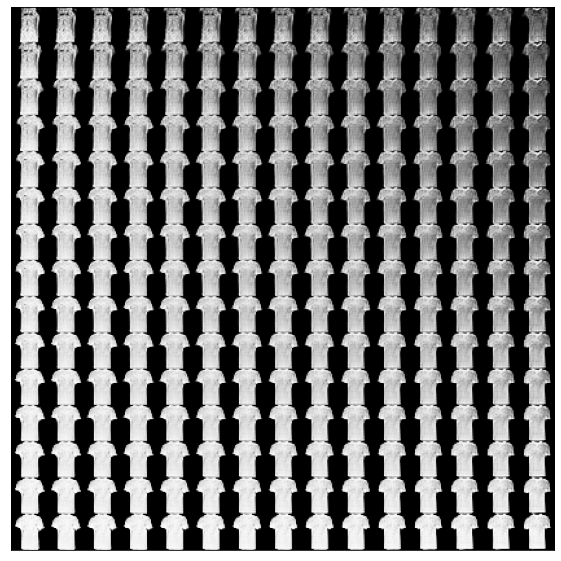

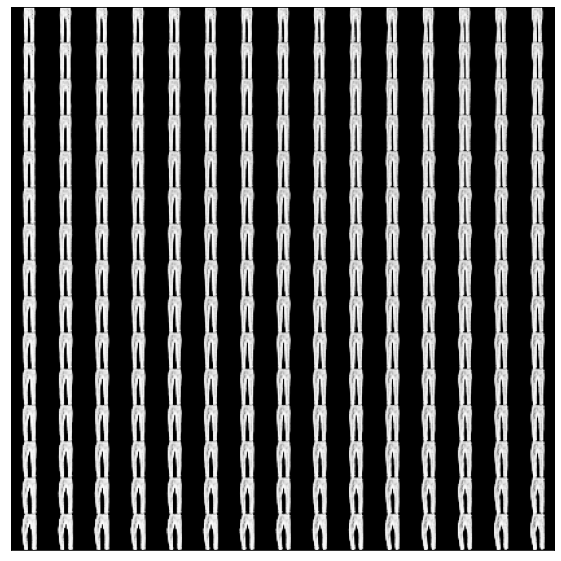

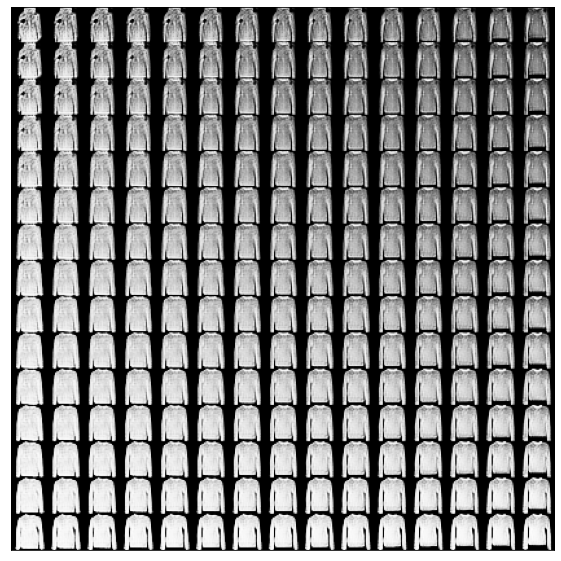

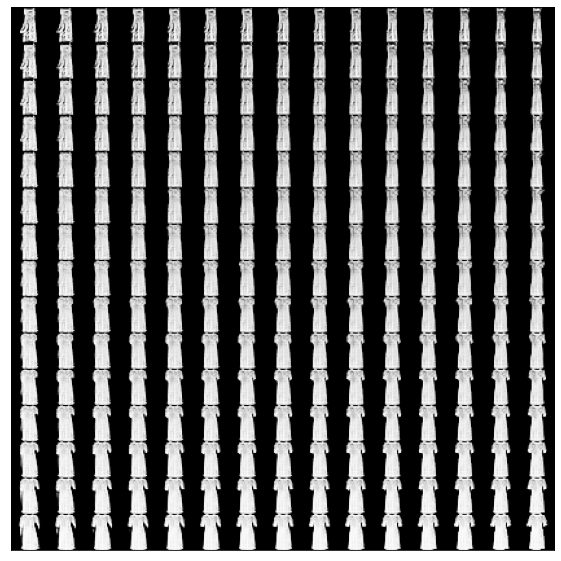

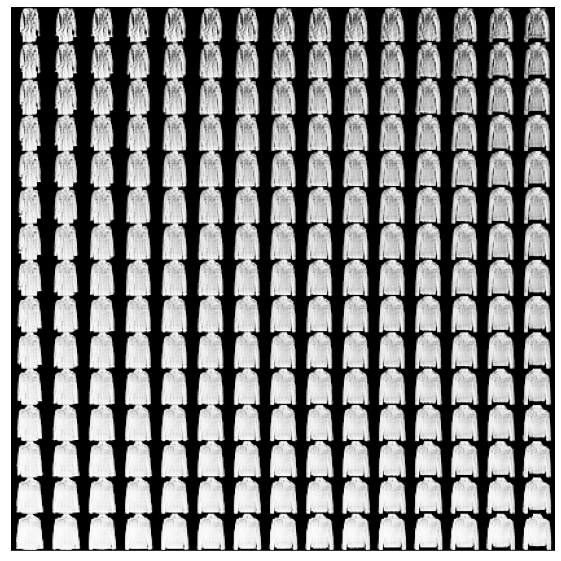

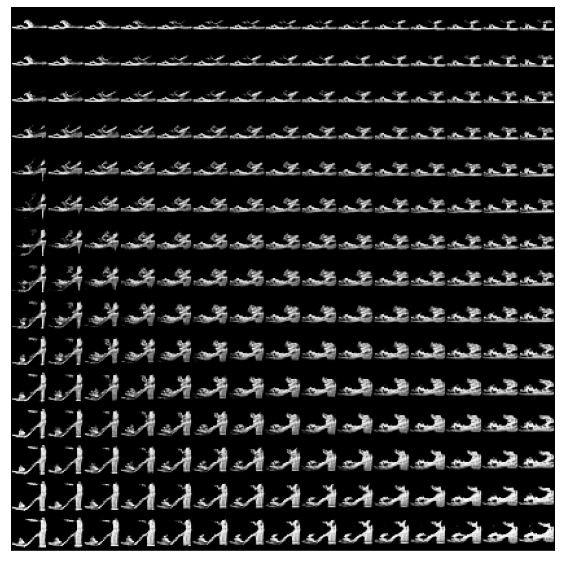

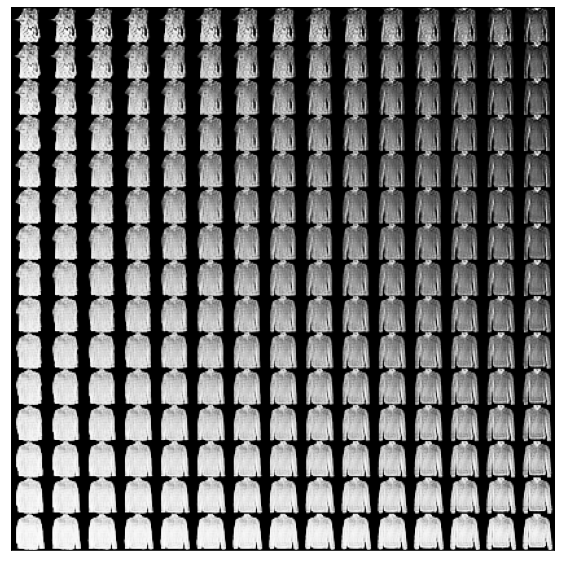

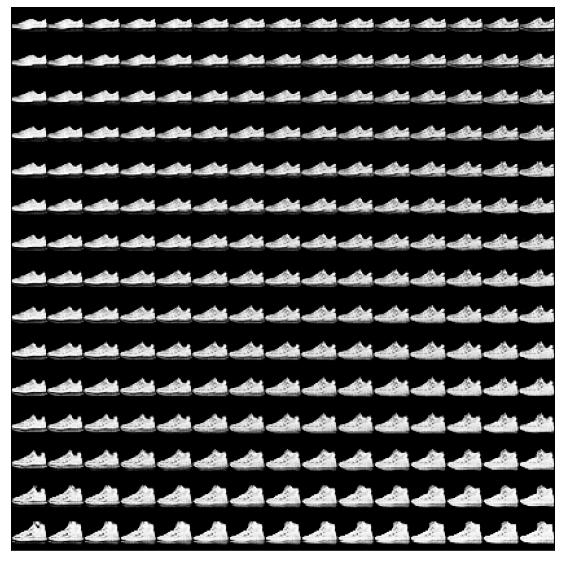

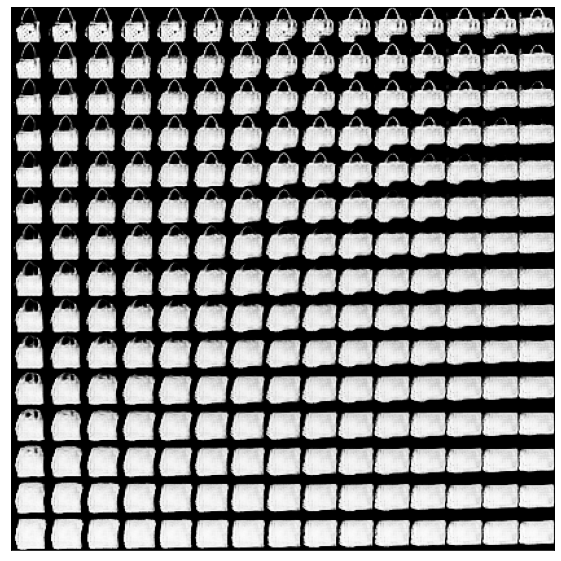

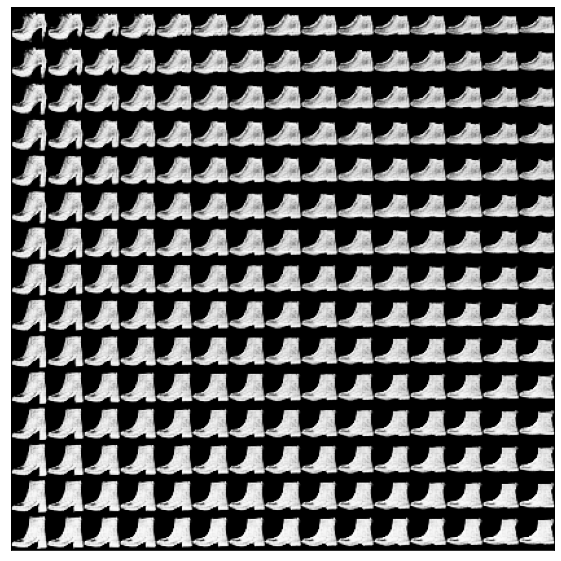

array([[6.02511518e-15, 9.68498184e-30, 1.49116882e-35, ...,
        2.69158583e-13, 4.20239156e-11, 2.57517208e-09],
       [7.80382278e-25, 0.00000000e+00, 0.00000000e+00, ...,
        2.72786568e-18, 9.96927801e-13, 2.74981565e-11],
       [3.65128361e-29, 0.00000000e+00, 0.00000000e+00, ...,
        2.37980169e-20, 9.32096400e-14, 8.02067668e-13],
       ...,
       [2.21115944e-04, 1.64554897e-03, 2.93465741e-02, ...,
        2.77663138e-26, 8.25648724e-24, 5.28125301e-19],
       [5.45313412e-07, 7.16719262e-09, 8.25133327e-07, ...,
        0.00000000e+00, 0.00000000e+00, 2.33334077e-31],
       [1.80948848e-06, 2.41870499e-11, 1.02121037e-11, ...,
        0.00000000e+00, 0.00000000e+00, 2.25185785e-31]])

In [5]:
from keras.layers import Dense, Input, Lambda, Flatten, concatenate, Reshape, RepeatVector
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import pickle as pkl
from keras.utils import to_categorical
from keras.datasets import fashion_mnist,mnist
from scipy.stats import norm
import tensorflow as tf
from time import time
from tensorflow.keras.callbacks import TensorBoard

tensorboard=TensorBoard(log_dir="logdir/{}".format(time()))

class VAEGAN:

  def __init__(self, digit_size, num_classes, latent_dim, sess_name=''):

    self.sess = tf.compat.v1.Session()
    self.digit_size = digit_size
    self.latent_dim = latent_dim

    self.gamma = 1  # parameter of training
    tf.compat.v1.disable_eager_execution()
    self.a = tf.compat.v1.placeholder(tf.float32, shape=(None, self.digit_size, self.digit_size, 1))
    self.b = tf.compat.v1.placeholder(tf.float32, shape=(None, num_classes))
    self.c = tf.compat.v1.placeholder(tf.float32, shape=(None, latent_dim))

    self.img = Input(tensor=self.a)
    self.lbls = Input(tensor=self.b)
    self.z = Input(tensor=self.c)
    


    #Encoder 

    with tf.compat.v1.variable_scope('encoder'):
        x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(self.img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = Flatten()(x)
        x = concatenate([x, self.lbls])
        h = Dense(64, activation='relu')(x)
        self.z_mean = Dense(latent_dim)(h)
        self.z_log_var = Dense(latent_dim)(h)
        z = Lambda(self.sampler, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])

    self.encoder = Model([self.img, self.lbls], [self.z_mean, self.z_log_var, z])

    #Decoder

    with tf.compat.v1.variable_scope('decoder'):

        x = concatenate([self.z, self.lbls])

        x = Dense(7*7*128, activation='relu')(x)
        x = Reshape((7, 7, 128))(x)
        x = UpSampling2D(size=(2, 2))(x)

        x = Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu')(x)

        x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)

        x = UpSampling2D(size=(2, 2))(x)

        dec_output = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)

    self.decoder = Model([self.z, self.lbls], dec_output)

    #Discriminator 

    with tf.compat.v1.variable_scope('discriminator'):

      x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(self.img)
      x = self.add_units_to_conv2d(x, self.lbls)

      x = MaxPooling2D((2, 2), padding='same')(x)

      x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
      x = MaxPooling2D((2, 2), padding='same')(x)

      # layer for activations compare
      l = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(x)

      h = Flatten()(x)
      disc_output = Dense(1, activation='sigmoid')(h)

    self.discriminator = Model([self.img, self.lbls], [disc_output, l])

    #GAN 

    self.z_mean, self.z_log_var, encoded = self.encoder([self.img, self.lbls])

    self.generated_img = self.decoder([encoded, self.lbls])

    self.generated_from_z = self.decoder([self.z, self.lbls])

    self.discr_real_img, self.d_l_real_img = self.discriminator([self.img, self.lbls])

    self.discr_fake_img, self.d_l_fake_img = self.discriminator([self.generated_img, self.lbls])

    self.discr_img_from_z, self.d_l_img_from_z = self.discriminator([self.generated_from_z, self.lbls])

    #Define Losses 

    self.L_prior = - 0.5 * tf.reduce_sum(1. + 
      tf.clip_by_value(self.z_log_var, -2, 2) - tf.square(self.z_mean) - 
      tf.exp(tf.clip_by_value(self.z_log_var, -2, 2)), axis=-1) / self.digit_size / self.digit_size


    self.L_Diss_Like = tf.reduce_sum(
      tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.sigmoid(self.d_l_real_img),
        logits=self.d_l_fake_img)) / self.digit_size / self.digit_size

    log_d_img   = tf.math.log(self.discr_real_img + 1e-10)
    log_d_gen_img = tf.math.log(1. - self.discr_fake_img + 1e-10)
    log_d_img_from_z = tf.math.log(1. - self.discr_img_from_z + 1e-10)

    self.DiscrLoss = -1 / 4 * tf.reduce_sum(log_d_img + log_d_gen_img + log_d_img_from_z) / self.digit_size / self.digit_size

    self.EncLoss = self.L_prior + self.L_Diss_Like
    self.DecLoss = self.gamma * self.L_Diss_Like - self.DiscrLoss

    #Optimizers 
    EncOpt =  tf.compat.v1.train.RMSPropOptimizer(0.001)
    DecOpt = tf.compat.v1.train.RMSPropOptimizer(0.0003)
    DiscrOpt = tf.compat.v1.train.RMSPropOptimizer(0.001)

    Enc_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, 'encoder')
    Dec_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, 'decoder')
    Discr_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')

    self.enc_step = EncOpt.minimize(self.EncLoss, var_list=Enc_vars)
    self.dec_step = DecOpt.minimize(self.DecLoss, var_list=Dec_vars)
    self.discr_step = DiscrOpt.minimize(self.DiscrLoss, var_list=Discr_vars)

    self.saver = tf.compat.v1.train.Saver()

    self.sess.run(tf.compat.v1.global_variables_initializer())

    

  def add_units_to_conv2d(self, conv2, units):
    dim1 = int(conv2.shape[1])
    dim2 = int(conv2.shape[2])
    dimc = int(units.shape[1])
    repeat_n = dim1*dim2
    units_repeat = RepeatVector(repeat_n)(self.lbls)
    units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
    return concatenate([conv2, units_repeat])

  def sampler(self, args):
    z_mean, z_log_var = args
    batch_size = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch_size, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

  def vae_train_step(self, data_batch, lbls_batch, z):
    l_prior, dec_image, l_dis_like, l_gan, _, _ = self.sess.run(
      [self.L_prior, self.generated_from_z, self.L_Diss_Like, self.DiscrLoss, self.enc_step, self.dec_step],
                      feed_dict={self.z:z, self.img:data_batch, self.lbls:lbls_batch, K.learning_phase():1})
    return l_prior, dec_image, l_dis_like, l_gan

  def discr_train_step(self, data_batch, lbls_batch, z):
    loss, _ = self.sess.run([self.DiscrLoss, self.discr_step], 
                            feed_dict={self.img: data_batch,
                                      self.lbls: lbls_batch,
                                      self.z: z,
                                      K.learning_phase(): 1})
    return loss

  def train(self, Images, Labels, batch_size, epochs, k_steps):

    saving_period = 50 # frequency of saving model

    for i in range(epochs):
        # Select a random batch of images
        idx = np.random.randint(0, Images.shape[0], batch_size)
        imgs = Images[idx]
        lbls = Labels[idx]
        zp = np.random.randn(batch_size, latent_dim)

        #Discriminator
        discr_loss = 0
        counter = 1
        for j in range(k_steps):
          loss = self.discr_train_step(imgs, lbls, zp)
          # next minibatch
          idx = np.random.randint(0, Images.shape[0], batch_size)
          imgs = Images[idx]
          lbls = Labels[idx]
          zp = np.random.randn(batch_size, latent_dim)

          discr_loss += loss

          if loss < 1.0:
            break

          counter += 1


        discr_loss /= counter

        #VAE 
        vae_loss = 0
        counter = 1
        for j in range(k_steps):
          l_prior, dec_image, l_dis_like, loss = self.vae_train_step(imgs, lbls, zp)
          vae_loss += loss
          if loss > 0.4:
            break
          # next minibatch
          idx = np.random.randint(0, Images.shape[0], batch_size)
          imgs = Images[idx]
          lbls = Labels[idx]
          zp = np.random.randn(batch_size, latent_dim)
          counter += 1

        vae_loss /= counter

        print ("%d [D loss: %f] [G loss: %f]" % (i, discr_loss, vae_loss))
        
        

  def generate(self, z, lbl):
    return self.sess.run(self.generator([self.z, self.lbls]), 
                        feed_dict={self.z: z,
                                  self.lbls: lbl,
                                  K.learning_phase(): 0})

  def draw_manifold(self, lbl):
        n = 15
        # Draw samples from manifold
        grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
        grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

        figure = np.zeros((self.digit_size * n, self.digit_size * n))
        input_lbl = np.zeros((1, 10))
        input_lbl[0, lbl] = 1
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = np.zeros((1, self.latent_dim))
                z_sample[:, :2] = np.array([[xi, yi]])

                x_decoded = self.sess.run(self.decoder([self.z, self.lbls]), 
                                                          feed_dict={self.z: z_sample,
                                                                    self.lbls: input_lbl,
                                                                    K.learning_phase(): 0})
                digit = x_decoded[0].squeeze()
                figure[i * self.digit_size: (i + 1) * self.digit_size,
                       j * self.digit_size: (j + 1) * self.digit_size] = digit

        # Visualization
        plt.figure(figsize=(10, 10), num='Manifold')
        plt.imshow(figure, cmap='Greys_r')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
        return figure

  def style_transfer(self, prototype, in_lbl, out_lbl):
    rows = prototype.shape[0]
    if isinstance(in_lbl, int):
        lbl = in_lbl
        in_lbl = np.zeros((rows, 10))
        in_lbl[:, lbl] = 1
    if isinstance(out_lbl, int):
        lbl = out_lbl
        out_lbl = np.zeros((rows, 10))
        out_lbl[:, lbl] = 1
    return self.vae.predict([prototype, in_lbl, out_lbl])


(x_train, y_train), (x_test, y_test) =fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))
y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)




# network parameters 
batch_size = 128
epochs = 2000
latent_dim = 10
digit_size = 28
num_classes = 10

vaegan = VAEGAN(digit_size, num_classes, latent_dim)
vaegan.train(x_train, y_train_cat, batch_size, epochs, 5)


vaegan.draw_manifold(0)
vaegan.draw_manifold(1)
vaegan.draw_manifold(2)
vaegan.draw_manifold(3)
vaegan.draw_manifold(4)
vaegan.draw_manifold(5)
vaegan.draw_manifold(6)
vaegan.draw_manifold(7)
vaegan.draw_manifold(8)
vaegan.draw_manifold(9)